In [3]:
# Import libraries
# transformers: Provides access to pre-trained models like CLAP.
from transformers import ClapModel, AutoProcessor

# librosa: Used for audio analysis and loading audio files.
import librosa

# os: Provides a way to interact with the operating system, like navigating directories.
import os

import torch
import pandas as pd
import numpy as np

In [ ]:
# Load CLAP model + processor
model = ClapModel.from_pretrained("laion/larger_clap_music")
processor = AutoProcessor.from_pretrained("laion/larger_clap_music")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/776M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/776M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
#Small test to print all the parameters of CLAP
print('total number of CLAP\'s parameters:', sum(p.numel() for p in model.parameters()))

total number of CLAP's parameters: 193913882


In [ ]:
#Calculating the size of the data of all the parameters
param_size = 0 # We are using a for loop to add size of all parameters os initialised as 0 at the beginning

for param in model.parameters():
    #In increments we are adding the size of each parameter given by formula
    #param.nelement() is giving total number of elements in each parameter
    #param.element_size() is giving size of element in bytes
    param_size += param.nelement() * param.element_size()

#Buffers are tensors but not learnable parameters but still take up space
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

#Total size adds buffer size and parameter size
#Converted into MB
size_all_mb = (param_size + buffer_size) / 1024**2
print('CLAP model size: {:.3f}MB'.format(size_all_mb))

CLAP model size: 740.294MB


In [4]:
#This section is to convert the uploaded zip files into folders
import zipfile

# Define the paths to your zip files
zip_files = ["Exp1.zip", "Exp2.zip", "Analysis.zip"]

# Define the directory where you want to extract the files
extract_dir = "/content/" # You can change this if you want to extract elsewhere

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract each zip file
for zip_file in zip_files:
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted {zip_file} to {extract_dir}")
    else:
        print(f"Error: {zip_file} not found.")

Extracted Exp1.zip to /content/
Extracted Exp2.zip to /content/
Extracted Analysis.zip to /content/


# Process audio

In [ ]:
#Code to open the file we want
audio_stimuli = []
stimuli_path = "/content/Exp1/Stimuli/" #/content/Exp2/Stimuli/ if we are running experiment 2

#This section adds all the audio waveforms into the list audio_stimuli
for file in os.listdir(stimuli_path):
    if file.endswith(".wav"):
        wav_path = os.path.join(stimuli_path, file)
        audio, sample_rate = librosa.load(wav_path, sr=48000)
        audio_stimuli.append(audio)

In [ ]:
audio_stimuli = []
stimuli_path = "/content/Exp1/Stimuli/"  #/content/Exp2/Stimuli/ if we are running experiment 2

#This section adds all the audio waveforms into the list audio_stimuli
for file in sorted(os.listdir(stimuli_path)):
    if file.endswith(".wav"):
        wav_path = os.path.join(stimuli_path, file)
        #Clap has already been trained on a sample rate of 48,000 so we should use what it knows already
        print(wav_path)
        audio, sample_rate = librosa.load(wav_path, sr=48000)
        audio_stimuli.append(audio)

/content/Exp1/Stimuli/01_B_CTu_1.wav
/content/Exp1/Stimuli/02_B_CTu_2.wav
/content/Exp1/Stimuli/03_B_Tu_3.wav
/content/Exp1/Stimuli/04_B_Tu_4.wav
/content/Exp1/Stimuli/05_B_CTb_1.wav
/content/Exp1/Stimuli/06_B_CTb_2.wav
/content/Exp1/Stimuli/07_B_BTb_3.wav
/content/Exp1/Stimuli/08_B_TTb_4.wav
/content/Exp1/Stimuli/09_B_Ho_3.wav
/content/Exp1/Stimuli/10_B_Ho_4.wav
/content/Exp1/Stimuli/11_B_Ho_5.wav
/content/Exp1/Stimuli/12_B_Tr_4.wav
/content/Exp1/Stimuli/13_B_PTr_5.wav
/content/Exp1/Stimuli/14_B_PTr_6.wav
/content/Exp1/Stimuli/15_W_CBa_1.wav
/content/Exp1/Stimuli/16_W_CBa_2.wav
/content/Exp1/Stimuli/17_W_Ba_3.wav
/content/Exp1/Stimuli/18_W_Ba_4.wav
/content/Exp1/Stimuli/19_W_BCl_2.wav
/content/Exp1/Stimuli/20_W_BCl_3.wav
/content/Exp1/Stimuli/21_W_ClB_4.wav
/content/Exp1/Stimuli/22_W_ClB_5.wav
/content/Exp1/Stimuli/23_W_ClB_6.wav
/content/Exp1/Stimuli/24_W_Ob_4.wav
/content/Exp1/Stimuli/25_W_Ob_5.wav
/content/Exp1/Stimuli/26_W_EH_4.wav
/content/Exp1/Stimuli/27_W_EH_5.wav
/content/Exp1

In [ ]:
#verifcation if we opened correct file
print(audio_stimuli)

[array([-2.6257991e-05, -1.8168332e-05,  4.3254666e-05, ...,
       -1.1775010e-05,  1.0805696e-06, -3.3297738e-08], dtype=float32), array([-2.1216942e-05, -4.7350541e-06,  1.5635709e-05, ...,
        2.8016274e-08, -1.7804325e-08,  6.9179218e-09], dtype=float32), array([-9.8106102e-06,  1.1119668e-05, -3.5152134e-05, ...,
       -3.4414730e-05, -1.3167290e-05,  4.1392400e-06], dtype=float32), array([-2.9096404e-06, -1.3023089e-05, -4.7573376e-06, ...,
       -3.4261415e-05, -2.2727640e-05,  2.1467149e-06], dtype=float32), array([ 2.7754413e-06, -7.0806864e-06,  1.1189784e-05, ...,
       -1.2227122e-06,  7.4793968e-07, -2.8134855e-07], dtype=float32), array([-6.7172846e-07,  5.4504471e-06, -5.0830917e-05, ...,
       -1.6670765e-06,  1.9083664e-06,  0.0000000e+00], dtype=float32), array([ 1.6268901e-05, -3.3643319e-05,  2.5531041e-05, ...,
       -3.3158278e-05, -2.5886366e-05,  7.7379474e-07], dtype=float32), array([ 6.1509754e-06,  2.7266901e-06, -4.9879025e-05, ...,
       -1.23645

In [ ]:
#Processes the audio waveform in the audio_stimuli list
#The process involves converting the audio files into tensors (As PyTorch deals with Tensors)
inputs = processor(audios=audio_stimuli, return_tensors="pt", padding=True, sampling_rate=48000)

#Inputs the tensors into the CLAP model to extract the audio embeddings
#These embeddings are numerical representations
audio_embeddings = model.get_audio_features(**inputs)

In [ ]:
#Returning dimensions of the tensors
#The 59 is how many audio files there are
#The 512 is the size of any audio embedding
print(audio_embeddings.shape)

torch.Size([59, 512])


# Process text

In [5]:
#This is generating the prompts for each section
#We have 2 sections of discrete and dimensional
#Each section has 2 subsections of perceived and induced
discrete_tags = ["happiness", "sadness", "anger", "tenderness", "fear"]

discrete_captions_perceived = ["I perceive this sound as " + tag for tag in discrete_tags]
print(discrete_captions_perceived)
discrete_captions_induced = ["This sound makes me feel " + tag for tag in discrete_tags]
print(discrete_captions_induced)

dimensional_tags = ["positive", "relaxed", "awake"]

dimensional_captions_perceived = ["I perceive this sound as " + tag for tag in dimensional_tags]
print(dimensional_captions_perceived)
dimensional_captions_induced = ["This sound makes me feel " + tag for tag in dimensional_tags]
print(dimensional_captions_induced)


['I perceive this sound as happiness', 'I perceive this sound as sadness', 'I perceive this sound as anger', 'I perceive this sound as tenderness', 'I perceive this sound as fear']
['This sound makes me feel happiness', 'This sound makes me feel sadness', 'This sound makes me feel anger', 'This sound makes me feel tenderness', 'This sound makes me feel fear']
['I perceive this sound as positive', 'I perceive this sound as relaxed', 'I perceive this sound as awake']
['This sound makes me feel positive', 'This sound makes me feel relaxed', 'This sound makes me feel awake']


In [ ]:
#Combines all the generated text prompts from previous cell into one list
all_tags = discrete_captions_perceived + discrete_captions_induced + dimensional_captions_perceived + dimensional_captions_induced

# NOTE: currently using only dimensional_captions_induced
tag_inputs = processor(text=dimensional_captions_induced, return_tensors="pt", padding=True)
tag_embeds = model.get_text_features(**tag_inputs)

NameError: name 'processor' is not defined

# Generate outputs

In [ ]:
#Computes the similaity matrix between each audio clip and text tag
#Computes this using dot product between the audio embeddings and text embeddings
sims = torch.matmul(audio_embeddings, tag_embeds.T)
print(sims.shape)

torch.Size([59, 3])


## Load csv files and extract related columns

In [6]:
IDim_path = '/content/Exp1/Data/IDim'
IDim_response_dfs = []

for file in os.listdir(IDim_path):
    if file.endswith(".csv"):
        file_path = os.path.join(IDim_path, file)
        try:
            df = pd.read_csv(file_path, sep=r'\s*,\s*', engine='python')
            # Crucial: Strip whitespace from column names
            df.columns = df.columns.str.strip()

            # Ensure required rating columns exist
            required_cols = ['positive', 'relaxed', 'awake']
            if all(col in df.columns for col in required_cols):
                # Select only the relevant columns and append to our list
                IDim_response_dfs.append(df[required_cols])
            else:
                print(f"Skipping file '{file_path}': Missing required columns ({required_cols}). Found columns: {df.columns.tolist()}")

        except Exception as e:
            print(f"Error reading or processing file {file_path}: {e}")


# Concatenate all individual DataFrames into one master DataFrame for human responses
if IDim_response_dfs:
    master_human_responses_df = pd.concat(IDim_response_dfs, ignore_index=True)
    print(f"Master human responses DataFrame shape: {master_human_responses_df.shape}\n")
    print(f"Master human responses (first 5 rows):\n{master_human_responses_df.head()}\n")
else:
    raise ValueError("No valid CSV files found or processed in IDim_path.")


           #---------

# mean_positive_vector = []
# mean_relaxed_vector = []
# mean_awake_vector = []

# num_rows = all_dfs[0].shape[0]

# for i in range(num_rows):
#     current_row_positives = []
#     current_row_relaxeds = []
#     current_row_awakes = []

#     # For the current row index 'i', collect values from all DataFrames
#     for df in all_dfs:
#         current_row_positives.append(df.iloc[i]['positive'])
#         current_row_relaxeds.append(df.iloc[i]['relaxed'])
#         current_row_awakes.append(df.iloc[i]['awake'])

#     # Calculate the mean for the current row across all files, for each column
#     mean_positive_vector.append(np.mean(current_row_positives))
#     mean_relaxed_vector.append(np.mean(current_row_relaxeds))
#     mean_awake_vector.append(np.mean(current_row_awakes))

# IDim_responses = {
#     'positive_vector': mean_positive_vector,
#     'relaxed_vector': mean_relaxed_vector,
#     'awake_vector': mean_awake_vector
# }

# print("\n--- Mean Vectors (Mean across CSVs for each row position) ---")
# print(f"Length of positive_vector: {len(IDim_responses['positive_vector'])}")
# print(f"Length of relaxed_vector: {len(IDim_responses['relaxed_vector'])}")
# print(f"Length of awake_vector: {len(IDim_responses['awake_vector'])}")

Master human responses DataFrame shape: (3835, 3)

Master human responses (first 5 rows):
   positive  relaxed  awake
0      4.98     4.98   4.99
1      3.94     5.02   4.96
2      5.51     5.03   5.02
3      4.93     5.05   4.97
4      4.43     4.44   4.95



In [7]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# === Step 1: Load timbre data ===
timbre_path = "/content/Analysis/Thesis_Ch5/TimbreToolbox/long_AT1_TimbreToolbox_220509.csv"
df = pd.read_csv(timbre_path)
df.columns = df.columns.str.strip()

# === Step 2: Extract first 59 unique audio files ===
unique_stims = df['stim'].drop_duplicates().iloc[1:60]
audio_df = df[df['stim'].isin(unique_stims)].copy()

# === Step 3: Group by audio ('stim') and average participant ratings ===
response_cols = ['positive', 'relaxed', 'awake']
available_responses = [col for col in response_cols if col in audio_df.columns]
if not available_responses:
    raise ValueError("❌ No 'positive', 'relaxed', or 'awake' columns found in data.")

response_avg = audio_df.groupby('stim')[available_responses].mean()

# === Step 4: Extract features starting from 'IQR_Pitch' onwards ===
start_col = audio_df.columns.get_loc('IQR_Pitch')
feature_cols = audio_df.columns[start_col:]

# Group by stim and average those numerical features
features_avg = audio_df.groupby('stim')[feature_cols].mean()

# === Step 5: Align features and labels ===
X = features_avg
Y = response_avg

# Standardize features
scaler = StandardScaler()
X = X.dropna()  # Drop any rows with NaNs
Y = Y.loc[X.index]  # Align Y with cleaned X
X_scaled = scaler.fit_transform(X)


# Train Lasso models and store results
lasso_models = {}
lasso_predictions = {}
for col in Y.columns:
    y = Y[col].values
    model = LassoCV(cv=5, random_state=42).fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    lasso_models[col] = model
    lasso_predictions[col] = {'y_true': y, 'y_pred': y_pred}

    print(f"✅ Lasso model trained for: {col} (α = {model.alpha_:.5f})")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.180e-03, tolerance: 6.329e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.584e-03, tolerance: 6.329e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.993e-03, tolerance: 6.329e

✅ Lasso model trained for: positive (α = 0.11491)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e-02, tolerance: 7.538e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.787e-03, tolerance: 7.538e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e-02, tolerance: 7.538e

✅ Lasso model trained for: relaxed (α = 0.21933)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.613e-03, tolerance: 2.287e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e-03, tolerance: 2.287e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e-03, tolerance: 2.287e

✅ Lasso model trained for: awake (α = 0.07477)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.796e-03, tolerance: 2.887e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.696e-03, tolerance: 2.887e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.548e-03, tolerance: 2.887e

In [8]:
print("\n✅✅ Training Complete!")
print(f"→ Number of audio samples used: {X.shape[0]}")
print(f"→ Number of features per sample: {X.shape[1]}")
print(f"→ Feature names (first 5): {list(X.columns[:5])}")
print(f"→ Target dimensions: {list(Y.columns)}")


✅✅ Training Complete!
→ Number of audio samples used: 56
→ Number of features per sample: 54
→ Feature names (first 5): ['IQR_Pitch', 'IQR_HarmonicSpectralDeviation', 'IQR_Tristimulus_1', 'IQR_Tristimulus_2', 'IQR_Tristimulus_3']
→ Target dimensions: ['positive', 'relaxed', 'awake']


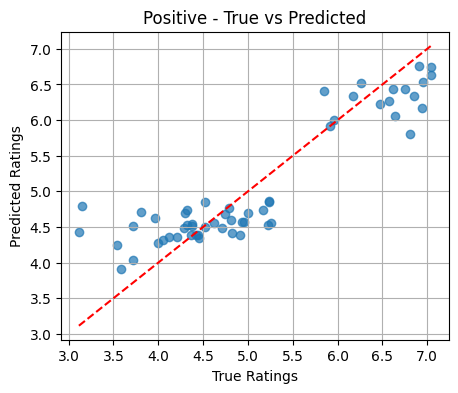

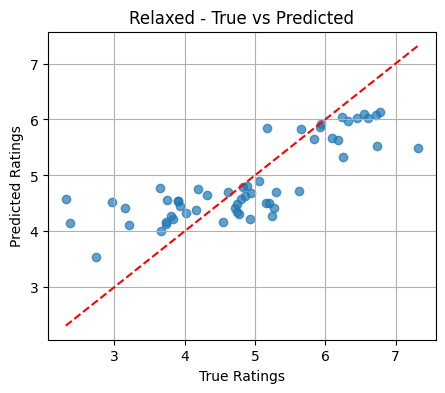

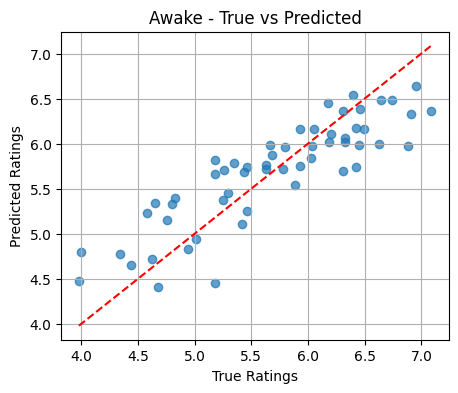

In [9]:
import matplotlib.pyplot as plt

for col, data in lasso_predictions.items():
    plt.figure(figsize=(5, 4))
    plt.scatter(data['y_true'], data['y_pred'], alpha=0.7)
    plt.plot([min(data['y_true']), max(data['y_true'])], [min(data['y_true']), max(data['y_true'])], 'r--')
    plt.title(f"{col.capitalize()} - True vs Predicted")
    plt.xlabel("True Ratings")
    plt.ylabel("Predicted Ratings")
    plt.grid(True)
    plt.show()

# Evaluate

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

print("📊 Lasso Regression Statistics\n" + "-" * 40)

maes = []
rmses = []
pearsons = []
r2s = []

for col, data in lasso_predictions.items():
    y_true = data['y_true']
    y_pred = data['y_pred']
    model = lasso_models[col]

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    r2 = model.score(X_scaled, y_true)

    maes.append(mae)
    rmses.append(rmse)
    pearsons.append(r)
    r2s.append(r2)

    print(f"\n📈 Dimension: {col}")
    print("→ MAE:", round(mae, 4))
    print("→ RMSE:", round(rmse, 4))
    print("→ Pearson Correlation:", round(r, 4))
    print("→ Non-zero Coefficients:", np.sum(model.coef_ != 0))
    print("→ R² Score:", round(r2, 4))


# Summary
print("\n📊 Overall Summary\n" + "-" * 25)
print("Average MAE:", round(np.mean(maes), 4))
print("Average RMSE:", round(np.mean(rmses), 4))
print("Average Pearson Correlation:", round(np.mean(pearsons), 4))
print("Average R² Score:", round(np.mean(r2s), 4))


📊 Lasso Regression Statistics
----------------------------------------

📈 Dimension: positive
→ MAE: 0.3766
→ RMSE: 0.2421
→ Pearson Correlation: 0.9078
→ Non-zero Coefficients: 9
→ R² Score: 0.8059

📈 Dimension: relaxed
→ MAE: 0.5974
→ RMSE: 0.5683
→ Pearson Correlation: 0.8104
→ Non-zero Coefficients: 5
→ R² Score: 0.6014

📈 Dimension: awake
→ MAE: 0.3356
→ RMSE: 0.1614
→ Pearson Correlation: 0.8695
→ Non-zero Coefficients: 7
→ R² Score: 0.7371

📊 Overall Summary
-------------------------
Average MAE: 0.4365
Average RMSE: 0.3239
Average Pearson Correlation: 0.8626
Average R² Score: 0.7148


# Test 1
895 iterations


Training/ Test split: 80/20


- Mean Absolute Error (MAE): 1.3614


- Root Mean Squared Error (RMSE): 1.7244

---
Pearson Correlation Coefficients (per dimension):


- Positive Dimension: 0.5249


- Relaxed Dimension: 0.5423


 - Awake Dimension: 0.3007


Average Pearson Correlation across dimensions: 0.4560
---